## Can you classify cards?
#### We expect you to use card images with their labels to classify unseen test images. You have to write a dataloader to read images from the folder 'cards/', write a CNN class, a loss function, a training loop, and check your test accuracy. 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

### Nothing to change here (This cell downloads and unzips the data in the folder 'cards/'). 

In [ ]:
!wget https://www.dropbox.com/s/gxcflnuuq0a64wx/cards.zip

!unzip cards.zip

!ls

### Dataloader
#####  Training and testing data sets are given in the folder 'cards/'. The training data is given as a folder of jpg images and a csv file that contain the class names associated with every image file. The testing data is also given in the same way. The class names can be turned into integer labels using the python dictionary below. 

In [ ]:
C = 53  # number of classes
class_names = ['ace of spades', 'seven of clubs', 'jack of clubs', 'two of clubs', 'queen of hearts', 
               'two of hearts', 'four of diamonds', 'queen of clubs', 'ten of spades', 'eight of diamonds', 
               'three of clubs', 'eight of hearts', 'three of diamonds', 'five of hearts', 'six of clubs', 
               'ten of diamonds', 'nine of clubs', 'ten of hearts', 'six of diamonds', 'king of diamonds', 
               'nine of hearts', 'eight of clubs', 'seven of hearts', 'five of spades', 'five of diamonds', 
               'four of hearts', 'queen of spades', 'four of spades', 'king of hearts', 'jack of spades', 
               'seven of diamonds', 'three of spades', 'jack of diamonds', 'six of spades', 'ace of hearts', 
               'king of clubs', 'nine of diamonds', 'ace of diamonds', 'eight of spades', 'nine of spades', 
               'queen of diamonds', 'jack of hearts', 'joker', 'two of diamonds', 'ten of clubs', 'seven of spades', 
               'two of spades', 'five of clubs', 'ace of clubs', 'six of hearts', 'king of spades', 'four of clubs', 
               'three of hearts']
names_to_labels = dict(zip(class_names, list(range(C))))

Write dataloaders that return images and labels for both the testing and training datasets. Use the transform below to resize the images to 56x56.

In [ ]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([56,56])])

class MyDataset(Dataset):
    def __init__(self, dataPath, csv_file, imagefold, trans=None):
        super().__init__()
        self.path = dataPath  # /content/cards
        self.csv_file = csv_file  # /cards_train.csv
        self.images = imagefold  # /content/cards/train_cards
        self.trans = trans
        self.df = pd.read_csv(f"{self.path}{self.csv_file}")  # /content/cards/cards_train.csv
        print(self.df.head)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        imPath = f"{self.path}{self.images}"
        im = Image.imread(f"{imPath}{df.iloc[idx,0]}")
        label = self.df.iloc[idx,1]
        if self.trans:
            im = self.trans(im)
        return (im, names_to_labels[label])

In [ ]:
df = pd.read_csv("/content/cards/cards_train.csv")
df.head
df.iloc[0,1]

'three of hearts'

<ipython-input-33-266ff76b8920>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread("/content/cards/train_cards/1.jpg")


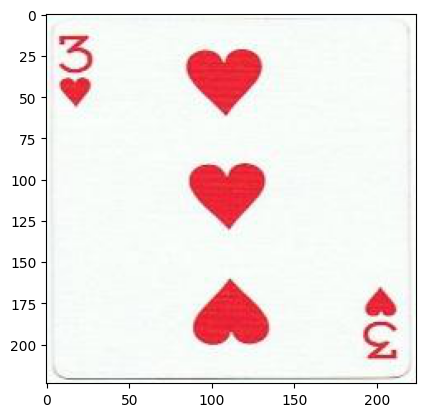

In [ ]:
im = Image.imread("/content/cards/train_cards/1.jpg")
plt.imshow(im)

#### Visualize the data


In [ ]:

dataset=MyDataset("/content/cards","/cards_train.csv","/train_cards/",trans)
train_loader = DataLoader(dataset, batch_size = 64, shuffle = True)

datasetTest=MyDataset("/content/cards","/cards_test.csv","/test_cards/",transforms.Compose([transforms.ToTensor(),transforms.Resize([56,56])]))
test_loader = DataLoader(dataset, batch_size = 64, shuffle = True)

<bound method NDFrame.head of      image_name       class_name
0         1.jpg  three of hearts
1         2.jpg  three of hearts
2         3.jpg  three of hearts
3         4.jpg  three of hearts
4         5.jpg  three of hearts
...         ...              ...
7619   7620.jpg     two of clubs
7620   7621.jpg     two of clubs
7621   7622.jpg     two of clubs
7622   7623.jpg     two of clubs
7623   7624.jpg     two of clubs

[7624 rows x 2 columns]>
<bound method NDFrame.head of     image_name       class_name
0        1.jpg  three of hearts
1        2.jpg  three of hearts
2        3.jpg  three of hearts
3        4.jpg  three of hearts
4        5.jpg  three of hearts
..         ...              ...
260    261.jpg     two of clubs
261    262.jpg     two of clubs
262    263.jpg     two of clubs
263    264.jpg     two of clubs
264    265.jpg     two of clubs

[265 rows x 2 columns]>


<ipython-input-31-0bc49bae9c1f>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{imPath}{df.iloc[idx,0]}")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weig

torch.Size([64, 3, 56, 56])
64


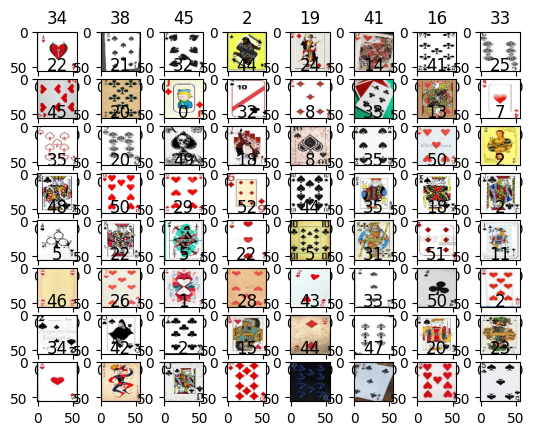

In [ ]:
batch = next(iter(train_loader))
print(batch[0].shape)
print(len(batch[1]))
for i in range(64):
  plt.subplot(8,8,i+1)
  plt.imshow(batch[0][i,:,:,:].permute(1, 2, 0))
  plt.title(batch[1][i].item())

### Define a CNN


In [ ]:
class My_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # 56
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,padding =2)
    self.bn1 = nn.BatchNorm2d(16)
    # 28
    self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,padding =2)
    self.bn2 = nn.BatchNorm2d(32)
    #14
    self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding =2)
    self.bn3  = nn.BatchNorm2d(64)
    # we did not now the input until forward
    self.linear1 = nn.Linear(64*7*7, 150)
    self.bn5= nn.BatchNorm1d(150)
    self.linear2= nn.Linear(150, 250)
    self.bn6= nn.BatchNorm1d(250)
    self.linear3 = nn.Linear(250,53)

  def forward(self, x):
      x = torch.relu(self.bn1(self.conv1(x)))
      x = F.max_pool2d(x,(2,2))
      x = torch.relu(self.bn2(self.conv2(x)))
      x = F.max_pool2d(x, (2,2))
      x = torch.relu(self.bn3(self.conv3(x)))
      x = F.max_pool2d(x, (2,2))
      x = x.view(-1,64*7*7)
      x = torch.relu(self.bn5(self.linear1(x)))
      x = torch.relu(self.bn6(self.linear2(x)))
      x = self.linear3(x)

      return x

## Loss 


In [ ]:
def loss_c(xhat,x):
  return F.cross_entropy(xhat,x)

### Training loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = My_CNN()
net = net.to(device)
num_epochs =10
lr = 0.2
mm = 0.5
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = mm)
# Learning rate Scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer , 0.5 , verbose = True)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    #set gradients to zero - because pytorch accomulate
    optimizer.zero_grad()
    X, y = (batch[0].type(torch.FloatTensor)/255).to(device), batch[1].to(device)
    # predict
    logits = net(X)
    #loss function
    loss = loss_c(logits,y)
    #calculating the gradients
    loss.backward()
    #Performs a single optimization step
    optimizer.step()
    # .item() extracts the loss’s value as a Python float.
    total_loss +=loss.item()
  scheduler.step()
  ls.append(total_loss/len(train_loader))
  print(f"[ Epoch {i+1}/10 ] Avg Loss:{ls[i]}")

Adjusting learning rate of group 0 to 2.0000e-01.


<ipython-input-31-0bc49bae9c1f>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{imPath}{df.iloc[idx,0]}")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weig

Adjusting learning rate of group 0 to 1.0000e-01.
[ Epoch 1/10 ] Avg Loss:2.474561028679212
Adjusting learning rate of group 0 to 5.0000e-02.
[ Epoch 2/10 ] Avg Loss:1.5519315550724666
Adjusting learning rate of group 0 to 2.5000e-02.
[ Epoch 3/10 ] Avg Loss:1.0911860977609953
Adjusting learning rate of group 0 to 1.2500e-02.
[ Epoch 4/10 ] Avg Loss:0.7564386961360773
Adjusting learning rate of group 0 to 6.2500e-03.
[ Epoch 5/10 ] Avg Loss:0.5693217992782593
Adjusting learning rate of group 0 to 3.1250e-03.
[ Epoch 6/10 ] Avg Loss:0.4777597983678182
Adjusting learning rate of group 0 to 1.5625e-03.
[ Epoch 7/10 ] Avg Loss:0.4292036660015583
Adjusting learning rate of group 0 to 7.8125e-04.
[ Epoch 8/10 ] Avg Loss:0.40449778363108635
Adjusting learning rate of group 0 to 3.9063e-04.
[ Epoch 9/10 ] Avg Loss:0.3981796616067489
Adjusting learning rate of group 0 to 1.9531e-04.
[ Epoch 10/10 ] Avg Loss:0.3827615742882093


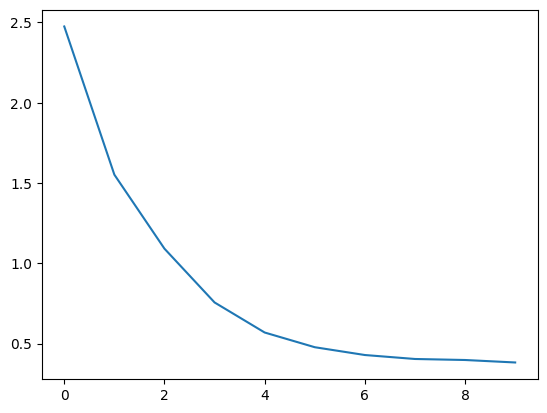

In [ ]:
plt.plot(ls)
plt.show()

## Check test accuracy

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for batch in test_loader:
    X,y = batch[0].to(device), batch[1].to(device)
    yhat = net(X)
    labels = torch.argmax(yhat, dim = 1)
    correct +=  torch.sum(labels==y)
    total += len(batch[1])


print(f"accuracy is {correct/total}")



<ipython-input-31-0bc49bae9c1f>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{imPath}{df.iloc[idx,0]}")


accuracy is 0.9264165759086609


#Resnet

In [ ]:
from torchvision.models import resnet18
net = resnet18(pretrained = True)

for params in net.parameters():
  params.requires_grad = False

net.fc = nn.Linear(in_features = 512 , out_features = 53 , bias = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
net = net.to(device)
num_epochs = 5
lr = 0.1
mm = 0.5
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = mm)
# Learning rate Scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer , 0.5 , verbose = True)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    #set gradients to zero - because pytorch accomulate
    optimizer.zero_grad()
    X, y = (batch[0].type(torch.FloatTensor)/255).to(device), batch[1].to(device)
    # predict
    logits = net(X)
    #loss function
    loss = loss_c(logits,y)
    #calculating the gradients
    loss.backward()
    #Performs a single optimization step
    optimizer.step()
    # .item() extracts the loss’s value as a Python float.
    total_loss +=loss.item()
  scheduler.step()
  ls.append(total_loss/len(train_loader))
  print(f"[ Epoch {i+1}/5 ] Avg Loss:{ls[i]}")

Adjusting learning rate of group 0 to 1.0000e-01.


<ipython-input-31-0bc49bae9c1f>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{imPath}{df.iloc[idx,0]}")


Adjusting learning rate of group 0 to 5.0000e-02.
[ Epoch 1/5 ] Avg Loss:3.7415085832277932
Adjusting learning rate of group 0 to 2.5000e-02.
[ Epoch 2/5 ] Avg Loss:2.4628336409727734
Adjusting learning rate of group 0 to 1.2500e-02.
[ Epoch 3/5 ] Avg Loss:2.017579651872317
Adjusting learning rate of group 0 to 6.2500e-03.
[ Epoch 4/5 ] Avg Loss:1.8035234779119491
Adjusting learning rate of group 0 to 3.1250e-03.
[ Epoch 5/5 ] Avg Loss:1.7445527344942093


In [ ]:
for params in net.parameters():
  params.requires_grad = True

In [ ]:
num_epochs = 5
lr = 0.001
mm = 0.5
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = mm)
# Learning rate Scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer , 0.5 , verbose = True)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    #set gradients to zero - because pytorch accomulate
    optimizer.zero_grad()
    X, y =(batch[0].type(torch.FloatTensor)/255).to(device), batch[1].to(device)
    # predict
    logits = net(X)
    #loss function
    loss = loss_c(logits,y)
    #calculating the gradients
    loss.backward()
    #Performs a single optimization step
    optimizer.step()
    # .item() extracts the loss’s value as a Python float.
    total_loss +=loss.item()
  scheduler.step()
  ls.append(total_loss/len(train_loader))
  print(f"[ Epoch {i+1}/5 ] Avg Loss:{ls[i]}")

Adjusting learning rate of group 0 to 1.0000e-03.


<ipython-input-31-0bc49bae9c1f>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{imPath}{df.iloc[idx,0]}")


Adjusting learning rate of group 0 to 5.0000e-04.
[ Epoch 1/5 ] Avg Loss:1.5991791953643164
Adjusting learning rate of group 0 to 2.5000e-04.
[ Epoch 2/5 ] Avg Loss:1.244249199827512
Adjusting learning rate of group 0 to 1.2500e-04.
[ Epoch 3/5 ] Avg Loss:1.094134783744812
Adjusting learning rate of group 0 to 6.2500e-05.
[ Epoch 4/5 ] Avg Loss:1.0374908154209455
Adjusting learning rate of group 0 to 3.1250e-05.
[ Epoch 5/5 ] Avg Loss:1.0236507192254067


In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for batch in test_loader:
    X,y = (batch[0].type(torch.FloatTensor)/255), batch[1].to(device)
    yhat = net(X)
    labels = torch.argmax(yhat, dim = 1)
    correct +=  torch.sum(labels==y)
    total += len(batch[1])


print(f"accuracy is {correct/total}")



<ipython-input-31-0bc49bae9c1f>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f"{imPath}{df.iloc[idx,0]}")


accuracy is 0.7459338903427124
